# Uplift Estimation for Individual Customers Based On Observational Data Using Causal Inference Methods

This notebook demonstrates how to analyze causal effects in marketing campaigns based on observational data at the level of individual customers. We focus on measuring how the treatment effect varies across the individuals (conditional average treatment effect (CATE)) and using these measurements to plan new campaigns.

### Use Case
We assume a marketing manager who analyzes a historical campaign with personalized offers. We further assume that the offers were targeted using unknown rules or targeting models and without A/B testing. Consequently, we have only observational data.
 
The available data consists of records representing individual customers. Each record corresponds includes customer's profile features, treatment variable (offer/no offer, offer type, etc.), and outcome variable (conversion, click, etc.). 

Our goal is to estimate the treatment effect on the outcome conditioned on the profile features (conditional average treatment effect (CATE)). We also would like to use this estimate to optimize targeting rules in future campaigns.

### Prototype: Approach and Data
We provide a simulator for generating observational data with confounders that impact both targeting decisions and outcomes. We then demonstrate how to estimate the variability of the treatment effect conditioned on customer features. Finally, we demonstrate how new campaigns can be planned based on the treatment effect estimates.

### Usage and Productization
It is recommended to start with modifying the simulator, treatment effect estimation, and campaign planning procedures according to your use case and data schema. Once the modified pipeline is tested using the simulator, it can be switched to real dataset.  

In [19]:
#
# Imports, settings, and helper functions
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor
from econml.dml import LinearDML

def print_df(df, header = None):
    if header is not None:
        print(f'{header}:')
    print(tabulate(df, headers='keys', tablefmt='psql'))

## Data Generation

We use a basic generation process with the following variables:
* `age` - observed real-valued customer attribute
* `has_membership` - observed binary customer attribute
* `is_offer` - indicates customers who were targeted with a special offer
* `is_conversion` - indicates conversion after a promotion campaign (outcome variable)

Both targeting decisions (`is_offer`) and conversions (`is_conversion`) are dependent on the customer attributes. Both `has_membership` and `age` variables have linear effect on the probabilities of targeting and conversion, but `age` also amplified the offer effect (older customers react on the offer more intensely than younger customers). 


Data sample:
+----+-------+------------------+------------+-----------------+
|    |   age | has_membership   | is_offer   | is_conversion   |
|----+-------+------------------+------------+-----------------|
|  0 |    30 | False            | False      | False           |
|  1 |    28 | False            | False      | False           |
|  2 |    31 | False            | False      | False           |
|  3 |    29 | False            | False      | False           |
|  4 |    25 | False            | False      | False           |
+----+-------+------------------+------------+-----------------+
Key statistics:
+--------+-------------+------------------+------------+-----------------+
|        |         age |   has_membership |   is_offer |   is_conversion |
|--------+-------------+------------------+------------+-----------------|
| count  | 200000      |           200000 |     200000 |          200000 |
| unique |    nan      |                2 |          2 |               2 |
| top    | 

Text(0, 0.5, 'Conversion rate')

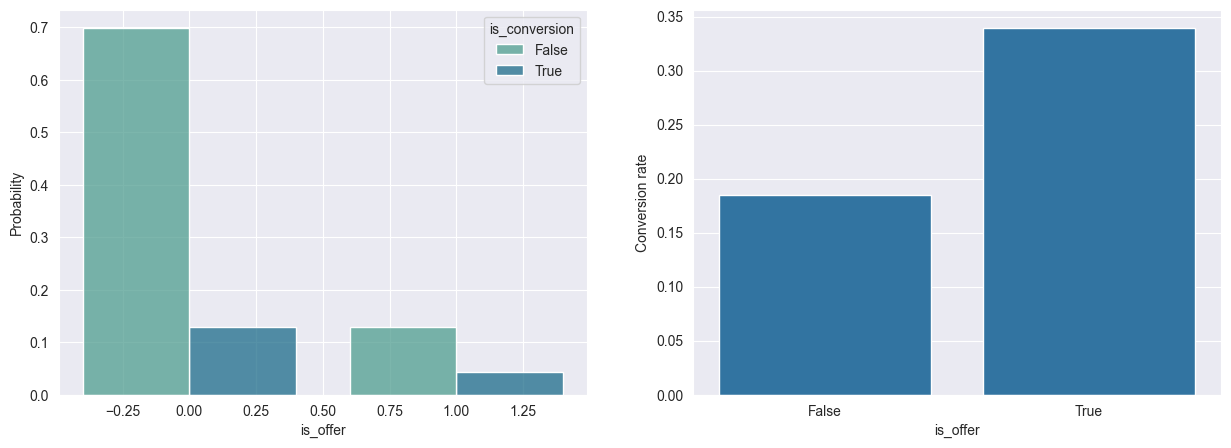

In [167]:
def generate_campaign_data(
        effect_membership_on_offer = 0.1,
        effect_age_on_offer = -0.1, 
        effect_offer_on_conversion = 0.05,
        effect_membership_on_conversion = 0.2, 
        effect_age_on_conversion = 0.1,
        effect_age_offer_on_conversion = 0.1,
        n = 200000, 
        rnd_seed = 42):
        
    rng = np.random.default_rng(rnd_seed)
    
    # Demographic features
    data = pd.DataFrame({
        'age': 20 + rng.binomial(40, 0.2, n),
        'has_membership': rng.binomial(1, 0.1, n)==1
    })
    data['age_std'] = MinMaxScaler().fit_transform(np.array(data['age']).reshape(-1,1))

    # Offers were targeted based on demographics
    data['is_offer'] = rng.uniform(size = n) < (
            0.20 +
            effect_membership_on_offer * data['has_membership'] +
            effect_age_on_offer        * data['age_std']
    )

    # Outcome depends both on the offer and demographics
    data['is_conversion'] = rng.uniform(size = n) < (
            0.10 +
            effect_offer_on_conversion       * data['is_offer'] +
            effect_membership_on_conversion  * data['has_membership'] +
            effect_age_on_conversion         * data['age_std'] +
            effect_age_offer_on_conversion   * (data['is_offer'] * data['age_std'])
    )
    
    data.drop(columns=['age_std'], inplace=True)
    
    return data

def get_true_age_effect(effect_offer_on_conversion, effect_age_offer_on_conversion, age):
    return effect_offer_on_conversion + age * effect_age_offer_on_conversion    

data = generate_campaign_data()

#
# Dataset preview and descriptive statistics
#
print_df(data.head(5), 'Data sample')
print_df(data.describe(include='all'), 'Key statistics') 


#
# Visualize the correlation between offers and conversion rates
#
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=data, x="is_offer", hue="is_conversion", palette="crest", 
             stat="probability", multiple="dodge", shrink=.8, discrete=True, ax=ax[0])
crosstab = pd.crosstab(data["is_offer"], data["is_conversion"])
offer_conversion_rate = crosstab.iloc[:, 1] / crosstab.iloc[:, 0]
sns.barplot(offer_conversion_rate, ax=ax[1])
plt.ylabel("Conversion rate")

## Uplift Estimation and Analysis

In this section, we estimate the offer effect (uplift) conditioned on `age`.

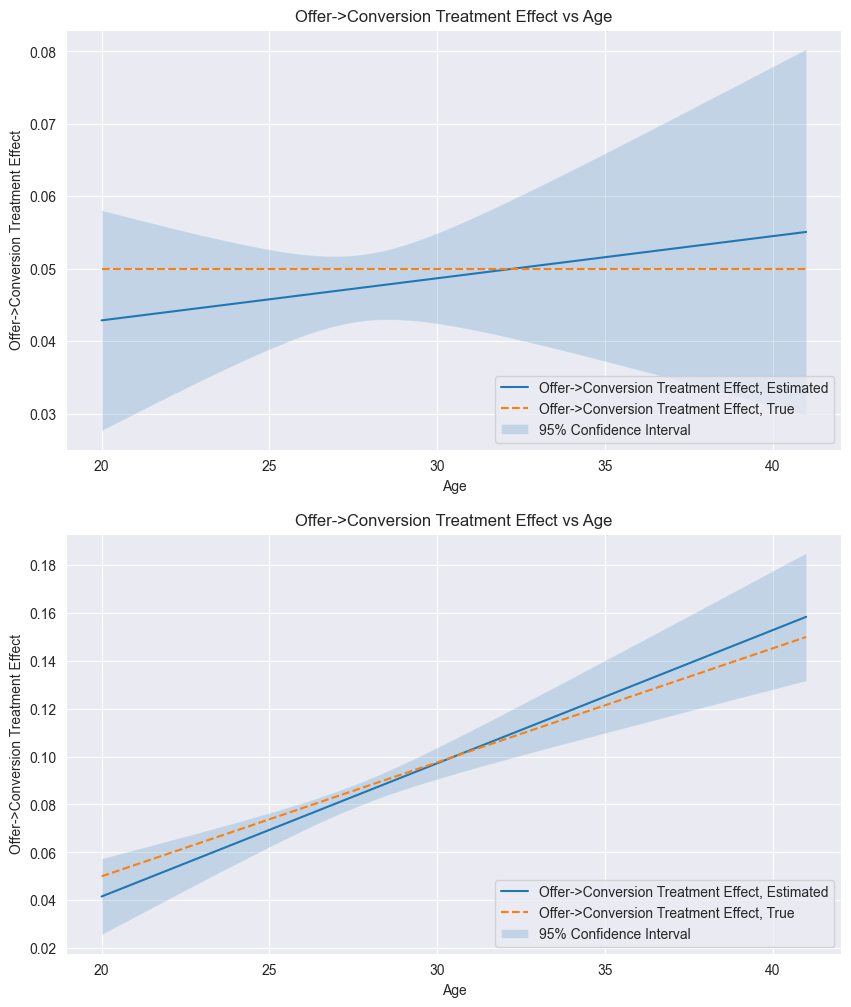

In [169]:
#
# Fit the treatment (offer) effect model on data
#
def age_effect_estimator(data):
    estimator = LinearDML(
        model_y=GradientBoostingRegressor(),
        model_t=GradientBoostingRegressor(),
    )

    estimator.fit(Y=data['is_conversion'], 
                  T=data['is_offer'], 
                  W=data[['age', 'has_membership']],
                  X=data[['age']])
    
    return estimator

# True baseline (non-personalized) offer->conversion treatment effect
te_offer_conversion_true = 0.05

_, ax = plt.subplots(2, 1, figsize=(10, 12))

# Evaluate different magnitudes of the (age x offer)->conversion effect
for i, te_age_offer_conversion_true in enumerate([0.0, 0.1]):
    #
    # Generate data and calculate the true treatment effect for each age
    #
    df = generate_campaign_data(effect_offer_on_conversion=te_offer_conversion_true,
                                effect_age_offer_on_conversion=te_age_offer_conversion_true)
    
    x_test = np.linspace(min(df['age']), max(df['age']), 100).reshape(-1, 1)
    x_test_std = MinMaxScaler().fit_transform(x_test.reshape(-1,1))
    
    te_true = get_true_age_effect(te_offer_conversion_true,  te_age_offer_conversion_true, x_test_std)

    #
    # Estimate the treatment effect for each age
    #
    est = age_effect_estimator(df)

    te_pred = est.effect(x_test).flatten()
    te_pred_interval = est.effect_interval(x_test)
    
    #
    # Plot the true and estimated effects
    #
    ax[i].plot(x_test.flatten(), te_pred, label="Offer->Conversion Treatment Effect, Estimated")
    ax[i].plot(x_test.flatten(), te_true, '--', label="Offer->Conversion Treatment Effect, True")
    ax[i].fill_between(
        x_test.flatten(),
        te_pred_interval[0].flatten(),
        te_pred_interval[1].flatten(),
        alpha=0.2,
        label="95% Confidence Interval",
    )
    ax[i].set_xlabel("Age")
    ax[i].set_ylabel("Offer->Conversion Treatment Effect")
    ax[i].set_title("Offer->Conversion Treatment Effect vs Age")
    ax[i].legend(loc="lower right")

## Campaign Planning

In this section, we create a more complete pipeline that estimates the treatment effect base on observational data and then uses this estimate to optimize targeting decisions. 

The cohorts that should be targeted: [31 32 33 34 35 36 37 38 39]


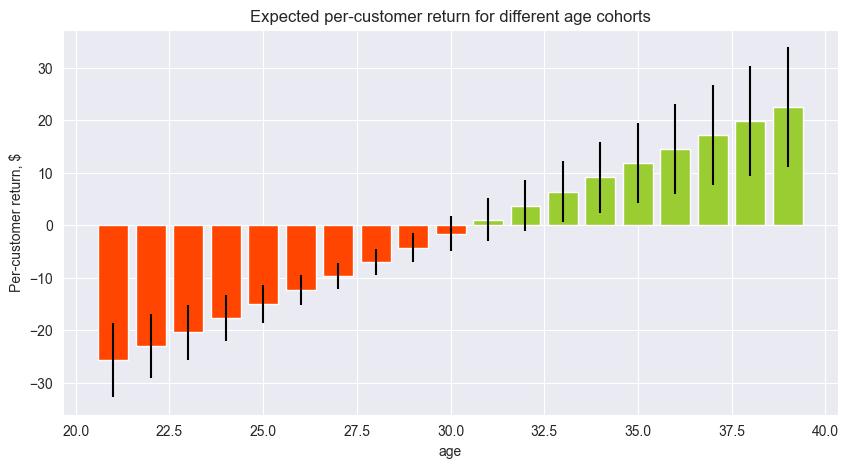

In [219]:
#
# Analyze the observational data
#
df = generate_campaign_data(effect_offer_on_conversion=0.05,
                            effect_age_offer_on_conversion=0.1)

est = age_effect_estimator(df)

#
# Population we potentially can target
#
rng = np.random.default_rng(seed=42)
x_population = pd.DataFrame(20 + rng.binomial(40, 0.2, 10000), columns=['age'])

#
# Estimate the treatment effect in each customer
#
te_mean = est.effect(x_population[['age']]).flatten()
te_interval = est.effect_interval(x_population[['age']])

population_metrics = pd.DataFrame({
    'age': x_population['age'],
    'te_mean': te_mean,
    'te_lower': te_interval[0],
    'te_upper': te_interval[1]
})

#
# Economic model for calculating the expected return 
# for each customer (mean and lower/upper bounds) 
#
offer_cost = 50
conversion_value = 500
for q in ['mean', 'upper', 'lower']:
    population_metrics[f'return_{q}'] = population_metrics[f'te_{q}']*conversion_value - offer_cost

#
# Aggregate the expected return by age cohort and visualize the difference
#
agg = population_metrics.groupby('age').mean()

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(agg.index, 
       agg['return_mean'], 
       yerr = [agg['return_mean'] - agg['return_lower'], 
               agg['return_upper'] - agg['return_mean']],
       color=np.where(agg['return_mean']>0, 'yellowgreen', 'orangered'))
ax.set_xlabel('age')
ax.set_ylabel('Per-customer return, $')
ax.set_title('Expected per-customer return for different age cohorts')

# Conclusion: the marketer should target only a subset of cohorts that deliver positive returns 
print(f"The cohorts that should be targeted: {agg[agg['return_mean']>0].index.values}")